In [1]:
#initializing pyspark
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'/Users/kpathak/opt/anaconda3/envs/mamlTesting/lib/python3.8/site-packages/pyspark'

In [4]:
#https://naomi-fridman.medium.com/install-pyspark-to-run-on-jupyter-notebook-on-windows-4ec2009de21f
#https://github.com/spark-examples/pyspark-examples/
#https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark
#https://www.guru99.com/pyspark-tutorial.html
#https://sparkbyexamples.com/pyspark/install-pyspark-in-anaconda-jupyter-notebook/
#follow conda install for pyspark and findaprk
#https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark

In [2]:
from pyspark.sql import SparkSession
sc =  SparkSession.builder \
    .master("local[1]") \
    .appName("OnlineReatilsData") \
    .getOrCreate()
spark= sc
print(spark)

22/10/27 18:08:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/27 18:09:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/27 18:09:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
spark

In [133]:
# spark.stop()

In [4]:
#reading csv data
#data source - https://archive.ics.uci.edu/ml/machine-learning-databases/00352/
df = spark.read.csv('/Users/kpathak/Downloads/Online Retail.csv',header=True,escape="\"")

In [5]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [6]:
df.count()

541909

In [7]:
df.show(5, truncate = False)

+---------+---------+-----------------------------------+--------+-------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate  |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |01/12/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |01/12/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |01/12/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |01/12/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |01/12/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+-------

In [8]:
#select column
df.select('CustomerID').distinct().count()

4373

In [9]:
#importing sql type functonalities like groupby
from pyspark.sql.functions import *
from pyspark.sql.types import *
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            4|
|             Italy|           15|
|              EIRE|            3|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            0|
|            Israel|            4|
|           Iceland|            1|
+------------------+-------------+
only showing top 20 rows



In [10]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|      Australia|            9|
|        Denmark|            9|
|Channel Islands|            9|
|    Netherlands|            9|
|          Japan|            8|
|         Sweden|            8|
|         Cyprus|            8|
|         Poland|            6|
|    Unspecified|            4|
+---------------+-------------+
only showing top 20 rows



In [12]:
#time based column parsing
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show(), df.select(min("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2031-10-11 17:19:00|
+-------------------+



+-------------------+
|          min(date)|
+-------------------+
|2001-02-11 08:23:00|
+-------------------+



(None, None)

In [16]:
#RFM Analysis
#recency
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [17]:
#most recent purchase
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df2.show(5)

+----------+---------+---------+--------------------+--------+-------------+---------+----------+--------------+-------------------+-------------------+
|   recency|InvoiceNo|StockCode|         Description|Quantity|  InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+----------+---------+---------+--------------------+--------+-------------+---------+----------+--------------+-------------------+-------------------+
|-318205980|   536384|    82484|WOOD BLACK BOARD ...|       3|01/12/10 9:53|     6.45|     18074|United Kingdom|2001-12-10 09:53:00|2012-01-10 08:26:00|
|-318205980|   536384|    84755|COLOUR GLASS T-LI...|      48|01/12/10 9:53|     0.65|     18074|United Kingdom|2001-12-10 09:53:00|2012-01-10 08:26:00|
|-318205980|   536384|    22464|HANGING METAL HEA...|      12|01/12/10 9:53|     1.65|     18074|United Kingdom|2001-12-10 09:53:00|2012-01-10 08:26:00|
|-318205980|   536384|    21324|HANGING MEDINA LA...|       6|01/12/10 9:53|     2

In [18]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [19]:
#Frequency
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))
df_freq.show()

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|     15574|        1|
|     17714|       10|
|     14157|        1|
|     16250|       10|
|     13772|       36|
|     13192|       33|
|     17686|       18|
|     16320|        9|
|     15271|        9|
|     13282|        8|
|     13865|        6|
|     15555|       68|
|     14887|        6|
|     17506|       16|
|     17427|        2|
|     12394|        6|
|     16504|       86|
|     15269|        2|
|     12847|       91|
|     15634|       15|
+----------+---------+
only showing top 20 rows



In [20]:
#merging the two tables
df3 = df2.join(df_freq,on='CustomerID',how='inner')
df3.show(5)

+----------+----------+---------+---------+--------------------+--------+-------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|   recency|InvoiceNo|StockCode|         Description|Quantity|  InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+----------+---------+---------+--------------------+--------+-------------+---------+--------------+-------------------+-------------------+---------+
|     18074|-318205980|   536384|    82484|WOOD BLACK BOARD ...|       3|01/12/10 9:53|     6.45|United Kingdom|2001-12-10 09:53:00|2012-01-10 08:26:00|       13|
|     18074|-318205980|   536384|    84755|COLOUR GLASS T-LI...|      48|01/12/10 9:53|     0.65|United Kingdom|2001-12-10 09:53:00|2012-01-10 08:26:00|       13|
|     18074|-318205980|   536384|    22464|HANGING METAL HEA...|      12|01/12/10 9:53|     1.65|United Kingdom|2001-12-10 09:53:00|2012-01-10 08:26:00|       13|
|     18074|-318205980

In [22]:
#total amount spent by the customer
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))
m_val.show(5)

+----------+------------------+
|CustomerID|    monetary_value|
+----------+------------------+
|     15574|              3.75|
|     17714|             153.0|
|     14157|            -32.45|
|     16250|             163.3|
|     13772|228.42000000000004|
+----------+------------------+
only showing top 5 rows



In [24]:
#final dataframe for RFM
finaldf = m_val.join(df3,on='CustomerID',how='inner')
finaldf.show(5)

+----------+-----------------+----------+---------+---------+--------------------+--------+-------------+---------+-------+-------------------+-------------------+---------+
|CustomerID|   monetary_value|   recency|InvoiceNo|StockCode|         Description|Quantity|  InvoiceDate|UnitPrice|Country|               date|          from_date|frequency|
+----------+-----------------+----------+---------+---------+--------------------+--------+-------------+---------+-------+-------------------+-------------------+---------+
|     12394|891.4000000000001|-134093880|   569997|    23245|SET OF 3 REGENCY ...|      32|07/10/11 8:08|     4.15|Denmark|2007-10-11 08:08:00|2012-01-10 08:26:00|        6|
|     12394|891.4000000000001|-134093880|   569997|    23295|SET OF 12 MINI LO...|     256|07/10/11 8:08|     0.72|Denmark|2007-10-11 08:08:00|2012-01-10 08:26:00|        6|
|     12394|891.4000000000001|-134093880|   569997|    23296|SET OF 6 TEA TIME...|     256|07/10/11 8:08|     1.04|Denmark|2007-10

In [25]:
#selecting only required columns
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()
finaldf.show(5)

+----------+---------+------------------+----------+
|   recency|frequency|    monetary_value|CustomerID|
+----------+---------+------------------+----------+
|-134093880|        6| 891.4000000000001|     12394|
| 184222200|       91| 871.5399999999998|     12847|
| 199866660|       33|464.32000000000005|     13192|
| 581230260|        8|428.40000000000003|     13282|
| 499763520|       20|118.24000000000001|     13610|
+----------+---------+------------------+----------+
only showing top 5 rows



In [34]:
#Standardization
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=['frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(5)


+----------+---------+------------------+----------+--------------------+--------------------+
|   recency|frequency|    monetary_value|CustomerID|            features|        standardized|
+----------+---------+------------------+----------+--------------------+--------------------+
|-134093880|        6| 891.4000000000001|     12394|[6.0,891.40000000...|[0.17795847439657...|
| 184222200|       91| 871.5399999999998|     12847|[91.0,871.5399999...|[2.69903686168142...|
| 199866660|       33|464.32000000000005|     13192|[33.0,464.3200000...|[0.97877160918117...|
| 581230260|        8|428.40000000000003|     13282|[8.0,428.40000000...|[0.23727796586210...|
| 499763520|       20|118.24000000000001|     13610|[20.0,118.2400000...|[0.59319491465525...|
+----------+---------+------------------+----------+--------------------+--------------------+
only showing top 5 rows



In [35]:
data_scale_output.select('standardized').show(2,truncate=False)

+----------------------------------------+
|standardized                            |
+----------------------------------------+
|[0.17795847439657758,0.6563171694143287]|
|[2.6990368616814266,0.641694711500296]  |
+----------------------------------------+
only showing top 2 rows



In [36]:
#Find count for selected columns
from pyspark.sql.functions import col,isnan,when,count
df_Columns=['frequency','monetary_value']
data_scale_output.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_Columns]
   ).show()

+---------+--------------+
|frequency|monetary_value|
+---------+--------------+
|        0|             0|
+---------+--------------+



In [38]:
data_scale_output.count()

4806

In [54]:
data_scale_output_sub=data_scale_output.limit(1000)

In [56]:
data_scale_output_sub.count()

1000

In [57]:
%%time
#running k-means clustering alogrithm
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output_sub)
    output=KMeans_fit.transform(data_scale_output_sub)
    cost[i] = KMeans_fit.summary.trainingCost

22/10/27 19:17:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/27 19:17:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


CPU times: user 404 ms, sys: 145 ms, total: 549 ms
Wall time: 3min 31s


In [58]:
cost

array([  0.        ,   0.        , 456.00488601, 269.21969166,
       206.1103414 , 177.99415799, 147.5151638 , 118.57886627,
       104.52147835,  84.42276338])

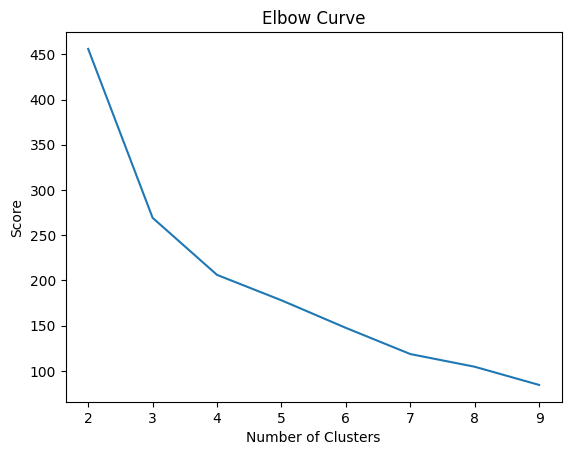

In [59]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [61]:
#final fitting k-means
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output_sub)

In [63]:
#predictions
preds=KMeans_fit.transform(data_scale_output_sub)
preds.show(5,0)

+----------+---------+------------------+----------+-------------------------+----------------------------------------+----------+
|recency   |frequency|monetary_value    |CustomerID|features                 |standardized                            |prediction|
+----------+---------+------------------+----------+-------------------------+----------------------------------------+----------+
|-134093880|6        |891.4000000000001 |12394     |[6.0,891.4000000000001]  |[0.17795847439657758,0.6563171694143287]|0         |
|184222200 |91       |871.5399999999998 |12847     |[91.0,871.5399999999998] |[2.6990368616814266,0.641694711500296]  |1         |
|199866660 |33       |464.32000000000005|13192     |[33.0,464.32000000000005]|[0.9787716091811768,0.3418680593476118] |3         |
|581230260 |8        |428.40000000000003|13282     |[8.0,428.40000000000003] |[0.23727796586210345,0.315420995486985] |0         |
|499763520 |20       |118.24000000000001|13610     |[20.0,118.24000000000001]|[0.59

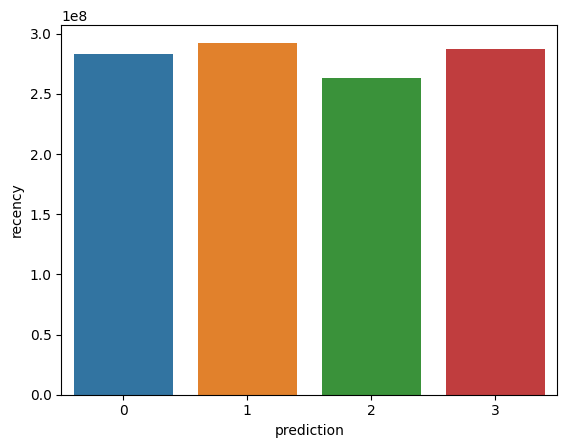

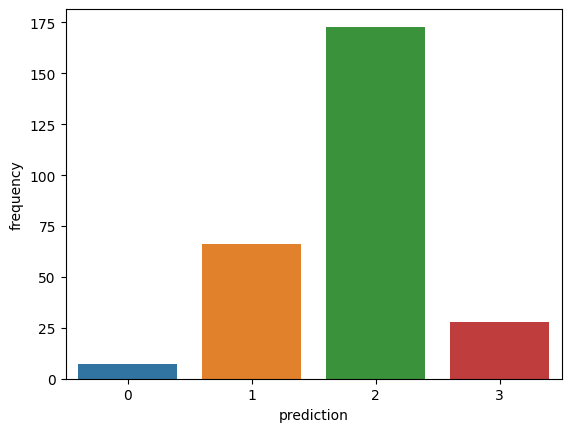

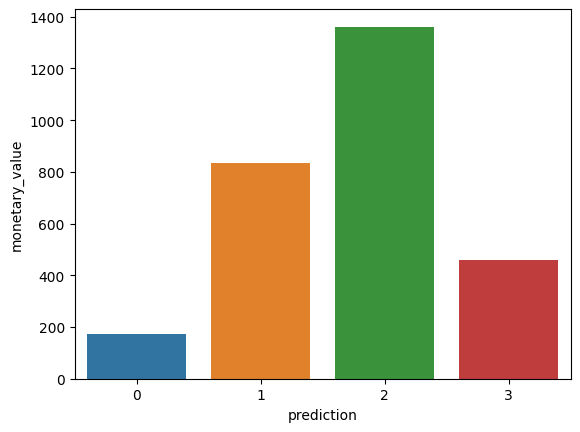

In [64]:
#cluster analysis
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()